<a href="https://colab.research.google.com/github/Yerra-Nikhitha/SARCASM-DETECTION-IN-HEADlines/blob/main/scrcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from wordcloud import WordCloud
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_json("./Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
# Let's use regex on the "article_link" column to get the source data.
df["source"] = df["article_link"].apply(lambda string: re.findall('[a-zA-Z]+', string)[2] )
df = df.drop(['article_link'],axis = 1)


In [7]:
df.head()

,is_sarcastic,headline,source
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


PREPROCESSING DATA

cleaning the head lines

In [8]:
df['headline'] = df['headline'].str.lower()
df['headline'] = df['headline'].apply(lambda x: re.sub('[^a-zA-Z\s]+|X{2,}', '', x))

# [@\^&\*\$] matches on the characters, you want to replace
#\S+matches on hash tags
# \S+[a-z0-9]\.(com|net|org) matches on domain names

df['headline'] = df['headline'].apply(lambda x: re.sub("[@\^&\*\$]|#\S+|\S+[a-z0-9]\.(com|net|org)"," ",x))


In [9]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the title, text
df['headline'] = df['headline'].apply(lambda x:expand_contractions(x))

In [10]:
df['CharCount'] = df['headline'].apply(lambda x: len(x))
df['WordCount'] = df['headline'].apply(lambda x: len(x.split()))

In [11]:
df.head(10)

,is_sarcastic,headline,source,CharCount,WordCount
0,1,thirtysomething scientists unveil doomsday clo...,theonion,61,8
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,77,13
2,0,eat your veggies deliciously different recipes,huffingtonpost,47,6
3,1,inclement weather prevents liar from getting t...,theonion,52,8
4,1,mother comes pretty close to using word stream...,theonion,59,9
5,0,my white inheritance,huffingtonpost,20,3
6,0,ways to file your taxes with less stress,huffingtonpost,41,8
7,1,richard bransons globalwarming donation nearly...,theonion,86,13
8,1,shadow government getting too large to meet in...,theonion,73,12
9,0,lots of parents know this scenario,huffingtonpost,34,6


In [12]:
df["source"].value_counts()

source
huffingtonpost    14985
theonion          13634
Name: count, dtype: int64

In [13]:
df["is_sarcastic"].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

VISUALIZATION

<Axes: title={'center': 'Length of sentence Distribution'}, xlabel='Length', ylabel='The Number of Sentence'>

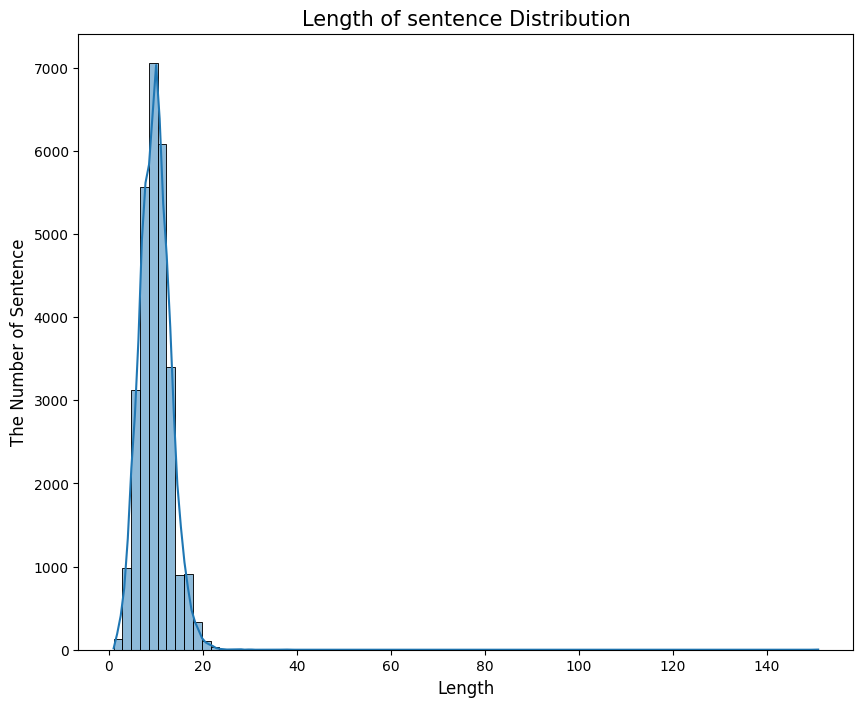

In [14]:
plt.figure(figsize = (10, 8))
plt.title('Length of sentence Distribution', fontsize=15)
plt.xlabel("Length", fontsize=12)
plt.ylabel("The Number of Sentence", fontsize=12)

sns.histplot(df, x='WordCount',
             kde = True,
             bins = 80
             )

In [15]:
fig = px.histogram(df['WordCount'], color=df['is_sarcastic'],
                   labels={'value': 'WordCount', 'color': 'is_sarcastic'},
                   color_discrete_map={0: "skyblue", 1: "gray"},
                   marginal='box')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the sentence length and sarcastic	',
                  title_x=0.5, title_font=dict(size=20))
fig.update_layout(barmode='overlay')
fig.show()

Text(0, 0.5, 'The Number of label')

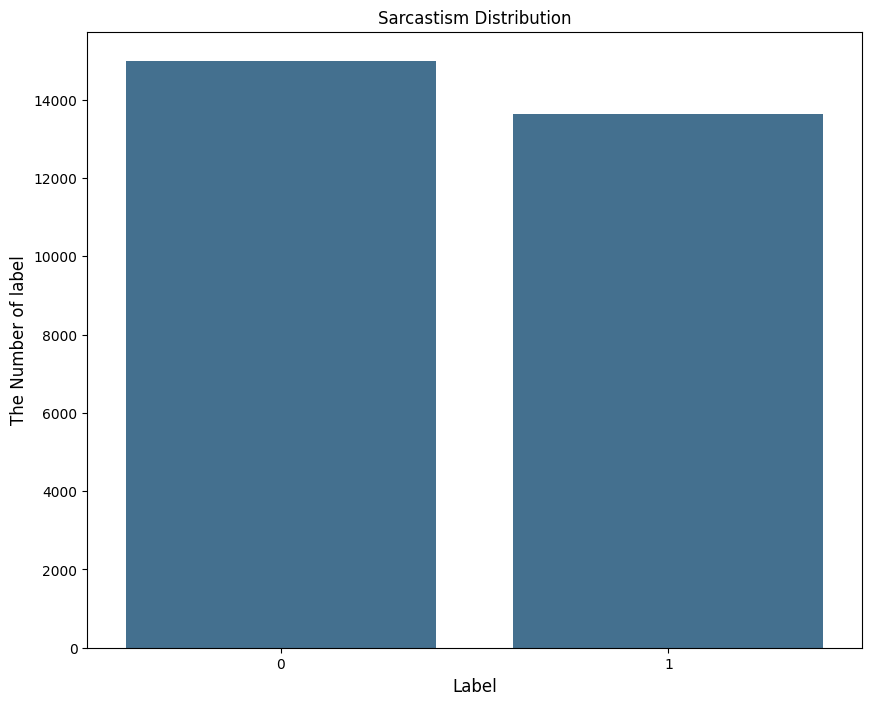

In [16]:
plt.figure(figsize = (10, 8))
sns.countplot(x = df.is_sarcastic, data = df, saturation=0.5)
plt.title('Sarcastism Distribution', fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.ylabel("The Number of label", fontsize=12)


Text(0, 0.5, 'Count')

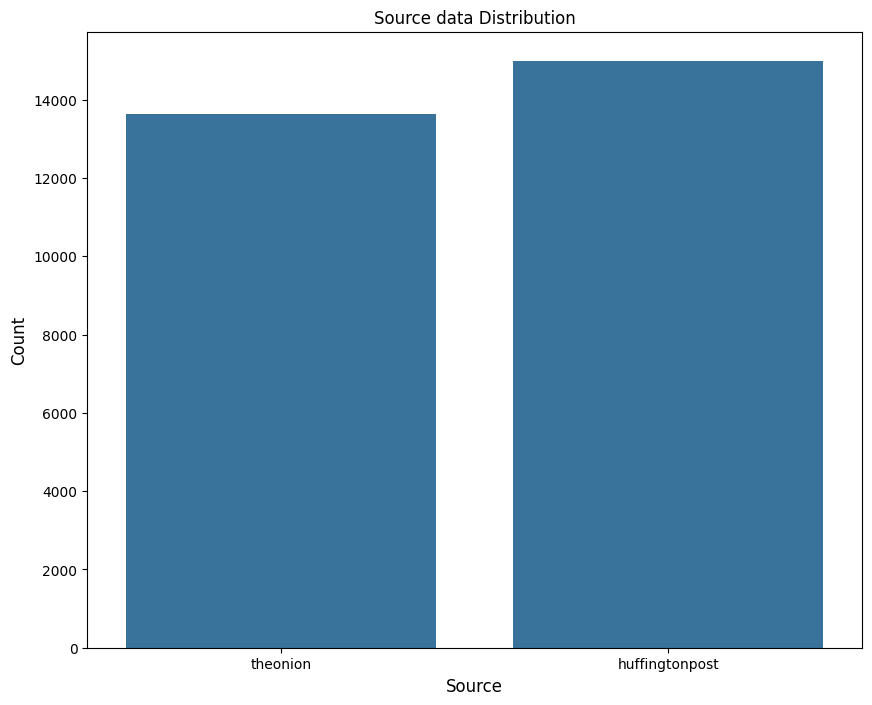

In [17]:
plt.figure(figsize = (10, 8))
sns.countplot(x = df.source, data = df, saturation=0.65)
plt.title('Source data Distribution', fontsize=12)
plt.xlabel("Source", fontsize=12)
plt.ylabel("Count", fontsize=12)


In [18]:
def get_top_nwords(x, n, i):
    vec = CountVectorizer(ngram_range=(i,i)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

In [19]:
# Bigram
words = get_top_nwords(df.headline, 20, 2)
df_bi = pd.DataFrame(words, columns=['Bigram', 'Frequency'])
df_bi.head()

,Bigram,Frequency
0,donald trump,366
1,of the,365
2,in the,360
3,to be,355
4,out of,268


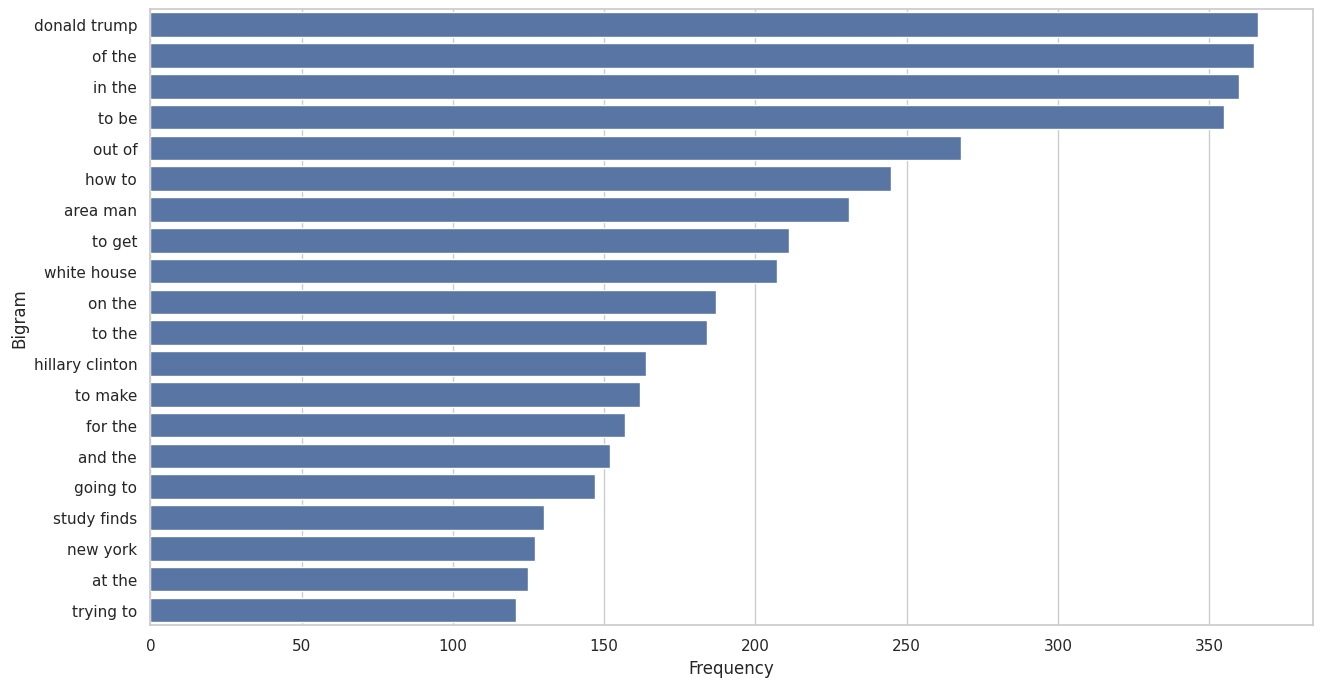

In [20]:
plt.figure(figsize = (15, 8))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y='Bigram', x='Frequency', orient = "h", data=df_bi)

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

There are 1769716 words in the combination of headlines.


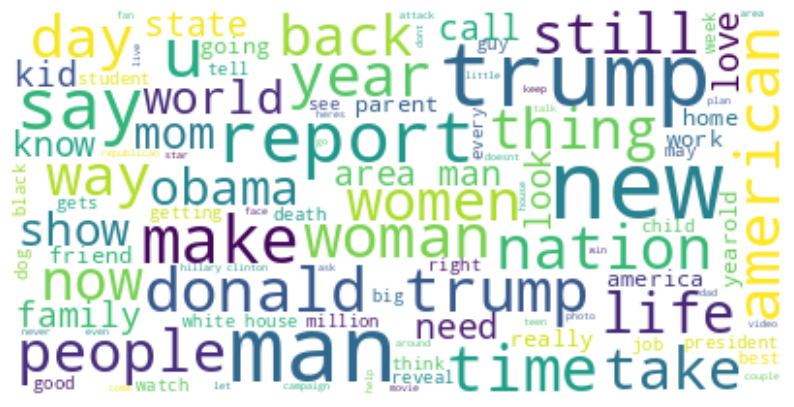

In [22]:
# Wordcloud
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["one", "first", "will", "want", "give"])


texts = " ".join(text for text in df.headline)
print ("There are {} words in the combination of headlines.".format(len(texts)))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100,
                      stopwords=stopwords,
                      background_color="white").generate(texts)

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("first_review.png")

TOKENIZER


In [23]:
def tokenize(text):
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [24]:
X = df.headline
Y = df.is_sarcastic
# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [25]:
import nltk
nltk.download(['punkt', 'wordnet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

RANDOM FOREST

In [26]:
# Instantiate transformers and classifier
vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()
clf = RandomForestClassifier()


# Fit and/or transform each to the training data
# Hint: you can use the fit_transform method
X_train_counts = vect.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_counts)

# Fit or train the classifier
clf.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



RandomForestClassifier()

In [27]:
# Transform test data
X_test_counts = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)

# Predict test labels
y_pred = clf.predict(X_test_tfidf)

In [28]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      4916
           1       0.80      0.79      0.80      4529

    accuracy                           0.81      9445
   macro avg       0.81      0.81      0.81      9445
weighted avg       0.81      0.81      0.81      9445



In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8051229298718807

GAUSSIAN NAIVE BAYES MODEL

In [30]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train_tfidf.toarray(), y_train)


# Predict test labels
y_pred = model.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.85      0.73      4916
           1       0.74      0.46      0.57      4529

    accuracy                           0.67      9445
   macro avg       0.69      0.66      0.65      9445
weighted avg       0.69      0.67      0.65      9445



In [31]:
roc_auc_score(y_test, y_pred)

0.6590592791307299

SVM

In [32]:
from sklearn import svm

In [33]:
model = svm.SVC(kernel='linear', gamma=1)

# Train the model using the training sets
model.fit(X_train_counts, y_train)

# Predict test labels
y_pred = model.predict(X_test_counts.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4916
           1       0.82      0.80      0.81      4529

    accuracy                           0.82      9445
   macro avg       0.82      0.82      0.82      9445
weighted avg       0.82      0.82      0.82      9445



In [34]:
roc_auc_score(y_test, y_pred)

0.8213223263657892

KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)

# Train the model using the training sets
knn.fit(X_train_tfidf.toarray(), y_train)

# Predict test labels
y_pred = knn.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      4916
           1       0.72      0.61      0.66      4529

    accuracy                           0.70      9445
   macro avg       0.70      0.70      0.69      9445
weighted avg       0.70      0.70      0.70      9445



In [36]:
roc_auc_score(y_test, y_pred)

0.6951453664217274

BERT

In [37]:
!pip install transformers==4.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 16.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [38]:
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [39]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [40]:
from torch.utils.data import Dataset
class Dataset():

    def __init__(self, X, Y):

        self.labels = np.array(Y)
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512,
                                # truncation=True,
                                return_tensors="pt") for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [41]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('prajjwal1/bert-tiny')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [42]:
def train(model, X,Y, learning_rate, epochs, batch_size):

    train = Dataset(X,Y)
    # , Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].squeeze(1).to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()


            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(X): .3f} | Train Accuracy: {total_acc_train / len(X): .3f}')


In [43]:
def evaluate(model, X,Y, batch_size):

    test = Dataset(X,Y)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size,shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    y_pred = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].squeeze(1).to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            y_pred.append(output.argmax(dim=1))

    return y_pred


In [44]:
EPOCHS = 5
batch_size = 32
model = BertClassifier()
LR = 0.01

train(model, X_train, y_train, LR, EPOCHS, batch_size)

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

100%|██████████| 600/600 [19:30<00:00,  1.95s/it]


Epochs: 1 | Train Loss:  0.022 | Train Accuracy:  0.525


100%|██████████| 600/600 [19:56<00:00,  1.99s/it]


Epochs: 2 | Train Loss:  0.022 | Train Accuracy:  0.525


100%|██████████| 600/600 [19:39<00:00,  1.97s/it]


Epochs: 3 | Train Loss:  0.022 | Train Accuracy:  0.525


100%|██████████| 600/600 [19:45<00:00,  1.98s/it]


Epochs: 4 | Train Loss:  0.022 | Train Accuracy:  0.525


100%|██████████| 600/600 [19:35<00:00,  1.96s/it]

Epochs: 5 | Train Loss:  0.022 | Train Accuracy:  0.525


In [45]:
y_pred = evaluate(model,X_test,y_test, batch_size)

In [46]:
y_pred_ = torch.cat(y_pred, dim=0)

In [47]:
y_pred_=y_pred_.cpu().detach().numpy()

In [48]:
print(classification_report(y_test.values, y_pred_))
print(roc_auc_score(y_test, y_pred_))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      4916
           1       0.00      0.00      0.00      4529

    accuracy                           0.52      9445
   macro avg       0.26      0.50      0.34      9445
weighted avg       0.27      0.52      0.36      9445

0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



100%|██████████| 600/600 [21:42<00:00,  2.17s/it]


Epochs: 1 | Train Loss:  0.022 | Train Accuracy:  0.525


 36%|███▌      | 215/600 [07:49<14:34,  2.27s/it]